In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import random
random.seed(0)
import torch
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_amd.csv')

In [2]:

data['Date'] = pd.to_datetime(data['Date'])
data = data[ data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
data = data[ data['Date'] >= pd.to_datetime('2013-01-01 00:00:00-04:00')]
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()
data.tail(3)

,Date,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,Close+1
10669,2022-12-27 00:00:00-05:00,63.869999,64.279999,62.970001,63.27,36086000,3.580215,28.581375,40.744299,-100.0,...,64.904483,3.196924,0.199686,62.259998,66.309998,63.625000,63.296061,64.069522,63.354633,62.570000
10670,2022-12-28 00:00:00-05:00,62.540001,63.540001,61.959999,62.57,39526500,3.072722,23.469149,48.356896,-100.0,...,65.066470,5.084485,0.226207,61.959999,64.660004,62.750000,62.554867,63.816341,62.618721,64.820000
10671,2022-12-29 00:00:00-05:00,63.639999,65.180000,63.060001,64.82,41428500,3.496299,58.907116,36.887101,100.0,...,65.433640,5.917257,0.836824,61.959999,65.180000,64.120001,64.702822,63.707736,63.450099,64.769997


In [3]:
data = data.drop(columns=['tema_2', 'tema_8'])
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NATR_3', 'RSI_3',
       'ADX_3', 'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'WILLR_3', 'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_100', 'Close+1'],
      dtype='object')

In [4]:


train = data[data['Date'] < pd.to_datetime('2022-01-01 00:00:00-04:00')]

val = data[data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
val = data[data['Date'] >= pd.to_datetime('2022-01-01 00:00:00-04:00')]

train = train.drop(columns=['Date'])
val = val.drop(columns=['Date'])


X_train = train.copy().drop(columns=['Close+1'])
y_train = pd.DataFrame()
y_train['Close+1'] = train[['Close+1']]

X_val = val.copy().drop(columns=['Close+1'])
y_val = pd.DataFrame()
y_val['Close+1'] = val[['Close+1']]
X_train.shape,X_val.shape,y_train.shape,y_val.shape


((2266, 24), (250, 24), (2266, 1), (250, 1))

In [5]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_train.shape, X_val.shape


((2266, 24), (250, 24))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled.shape, X_val_scaled.shape


((2266, 24), (250, 24))

In [7]:
from torch.utils.data import DataLoader,Dataset
sequence_length= 5
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y,sequence_length=5):
        self.X =  torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i): 
       
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        elif self.sequence_length==1:
            return self.X[i],self.y[i]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            #print(padding.shape, x.shape)
            x = torch.cat((padding, x), 0)
            # x = self.X[0:i, :]
            #print(x.shape,padding.shape)

        return x, self.y[i]
       
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, sequence_length=sequence_length)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, sequence_length=sequence_length)

In [8]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(24, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
losses = []
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f"train Error: Avg loss: {train_loss/num_batches:>8f}")
    losses.append((train_loss/num_batches))

In [12]:
val = []
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    val.append(test_loss)
    
    scheduler.step()
    #curr_lr = optimizer.param_groups[0]['lr']

    print(f"Test Error: Avg loss: {test_loss:>8f}  \n")

In [13]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=200, gamma=0.1)

epochs = 2000
for t in range(epochs):
    if epochs %100==0:
        
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")




Epoch 1
-------------------------------
train Error: Avg loss: 1781.605805
Test Error: Avg loss: 6554.253784  

Epoch 2
-------------------------------
train Error: Avg loss: 1410.989333
Test Error: Avg loss: 5153.550201  

Epoch 3
-------------------------------
train Error: Avg loss: 1196.215975
Test Error: Avg loss: 4136.052185  

Epoch 4
-------------------------------
train Error: Avg loss: 928.470813
Test Error: Avg loss: 3230.249298  

Epoch 5
-------------------------------
train Error: Avg loss: 768.947880
Test Error: Avg loss: 2592.120453  

Epoch 6
-------------------------------
train Error: Avg loss: 658.342880
Test Error: Avg loss: 2102.383003  

Epoch 7
-------------------------------
train Error: Avg loss: 537.027550
Test Error: Avg loss: 1668.243610  

Epoch 8
-------------------------------
train Error: Avg loss: 462.265566
Test Error: Avg loss: 1344.365595  

Epoch 9
-------------------------------
train Error: Avg loss: 405.299417
Test Error: Avg loss: 1143.748302  

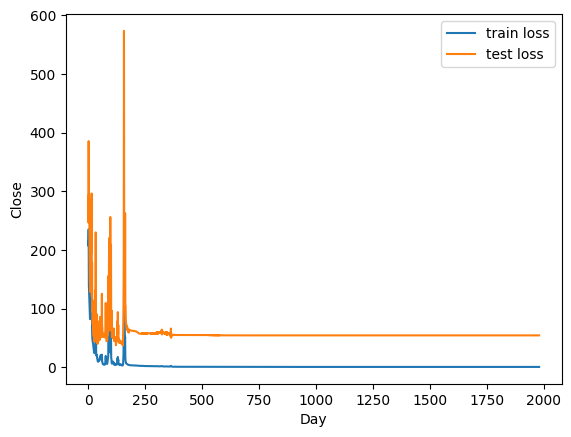

In [14]:
plt.plot(losses[20:], label='train loss')
plt.plot(val[20:], label='test loss')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

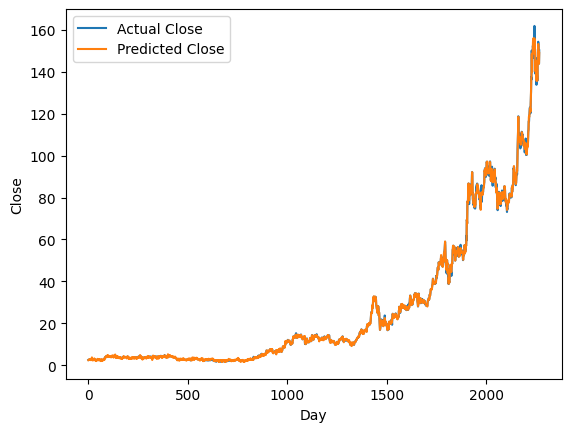

(tensor([94.0286]), array([94.77999878]))

In [15]:


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
count =0
output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in train_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        #print(X.shape,y.shape )
        #print(X.shape)
#print(count)
plt.plot(y_train, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
output[2000],y_train[2000]

torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([58, 5, 24]) torch.Size([58, 1])


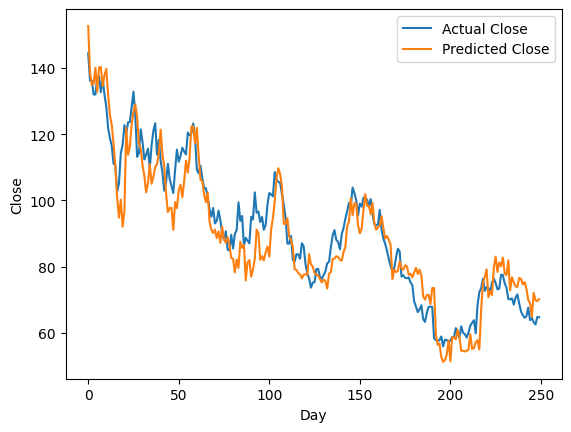

In [16]:

output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        print(X.shape,y.shape )
plt.plot(y_val, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [17]:
for batch, (X, y) in enumerate(train_dataset):
    print( (X.shape, y.shape))
    print( batch,(X, y))
    break

(torch.Size([5, 24]), torch.Size([1]))
0 (tensor([[-0.7130, -0.7142, -0.7140, -0.7135, -0.5357,  0.7252,  0.6802,  0.1814,
          1.1504,  0.8146, -0.3438, -0.6620,  1.1862, -1.1676, -0.2644, -0.7198,
         -0.7174, -0.7146,  1.5675,  1.1005, -0.7179, -0.7160, -0.7142, -0.7392],
        [-0.7130, -0.7142, -0.7140, -0.7135, -0.5357,  0.7252,  0.6802,  0.1814,
          1.1504,  0.8146, -0.3438, -0.6620,  1.1862, -1.1676, -0.2644, -0.7198,
         -0.7174, -0.7146,  1.5675,  1.1005, -0.7179, -0.7160, -0.7142, -0.7392],
        [-0.7130, -0.7142, -0.7140, -0.7135, -0.5357,  0.7252,  0.6802,  0.1814,
          1.1504,  0.8146, -0.3438, -0.6620,  1.1862, -1.1676, -0.2644, -0.7198,
         -0.7174, -0.7146,  1.5675,  1.1005, -0.7179, -0.7160, -0.7142, -0.7392],
        [-0.7130, -0.7142, -0.7140, -0.7135, -0.5357,  0.7252,  0.6802,  0.1814,
          1.1504,  0.8146, -0.3438, -0.6620,  1.1862, -1.1676, -0.2644, -0.7198,
         -0.7174, -0.7146,  1.5675,  1.1005, -0.7179, -0.7160, -

In [18]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(output,y_val))

7.393563404026705

In [19]:
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_amd.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()

test = data[data['Date'] >= pd.to_datetime('2023-01-01 00:00:00-04:00')]
test = test.drop(columns=['Date','tema_2','tema_8'])
test

,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBL_3_2.0,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_100,Close+1
10673,66.000000,66.879997,63.590000,64.019997,46851800,4.110550,43.227376,40.566151,100.000000,2.317400,...,63.804846,64.536664,65.268483,2.267915,0.146997,63.060001,66.879997,65.234999,63.464409,64.660004
10674,65.000000,65.790001,63.310001,64.660004,47477100,3.952655,57.191880,42.429407,10.753448,-0.246831,...,63.821951,64.483332,65.144714,2.051326,0.633562,63.139999,66.879997,64.550001,63.371049,62.330002
10675,64.150002,64.349998,62.299999,62.330002,46159500,3.943359,24.407318,30.501317,-100.000000,-3.767168,...,61.704227,63.670001,65.635775,6.174882,0.159168,62.299999,66.879997,63.324999,63.149205,63.959999
10676,63.150002,64.300003,60.049999,63.959999,70161300,5.243824,52.799692,39.568982,-59.824010,-0.093717,...,61.697703,63.650002,65.602300,6.134481,0.579393,60.049999,65.790001,62.175001,63.034524,67.239998
10677,66.220001,69.320000,65.669998,67.239998,69741300,6.479737,77.878709,41.140061,100.000000,3.990093,...,60.426246,64.510000,68.593753,12.660838,0.834251,60.049999,69.320000,67.494999,63.118892,68.050003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,112.070000,112.760002,109.839996,111.239998,58347200,3.230614,53.049678,36.721870,100.000000,3.469441,...,109.677250,110.599998,111.522747,1.668624,0.846790,107.080002,112.760002,111.299999,120.950636,113.910004
10796,113.029999,114.690002,112.410004,113.910004,53331900,3.091800,74.737893,41.386671,100.000000,3.188699,...,108.627862,111.773333,114.918804,5.628303,0.839642,107.629997,114.690002,113.550003,121.104594,115.820000
10797,115.160004,116.730003,114.510002,115.820000,31860000,2.737813,83.109892,51.287612,94.507029,5.128439,...,109.899988,113.656667,117.413346,6.610574,0.787932,109.839996,116.730003,115.620003,121.355605,113.949997
10798,116.099998,117.660004,113.860001,113.949997,49501600,3.058771,55.902291,60.012046,27.307241,2.436173,...,112.777792,114.560000,116.342208,3.111396,0.328863,112.410004,117.660004,115.760002,121.479762,113.480003


/usr/local/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([63, 5, 24]) torch.Size([63, 1])


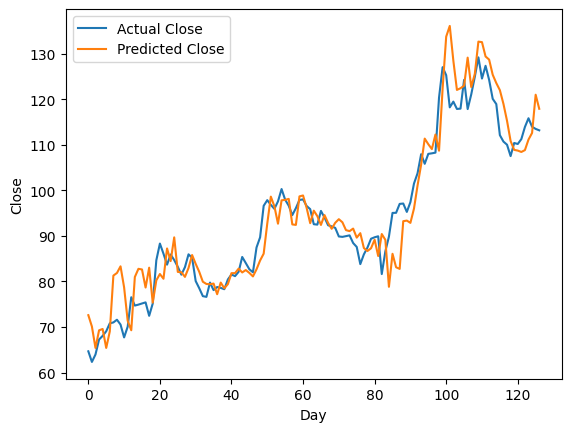

5.355731019294015

In [20]:



X_test = test.copy().drop(columns=['Close+1'])
y_test = pd.DataFrame()
y_test['Close+1'] = test[['Close+1']]

#X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

X_test_scaled = scaler.transform(X_test)

test_dataset = TimeSeriesDataset(X_test_scaled,y_test,sequence_length=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        print(X.shape,y.shape )
#print(count)
plt.plot(y_test, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
np.sqrt(mean_squared_error(output,y_test))


In [21]:
y_test.shape, X_test_scaled.shape, output.shape

((127, 1), (127, 24), torch.Size([127, 1]))

In [22]:
(np.abs(output-y_test)/y_test).mean()*100


tensor(4.4321, dtype=torch.float64)